In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

*Feature Engineering for labeled data*

In [2]:
df = pd.read_csv("tweets_labeled.csv")
df.head()

,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


In [4]:
# Check if there is any missing value.
df.isnull().sum()

tweet_id    0
tweet       1
date        0
label       0
dtype: int64

In [5]:
# Remove the row if any column containing Null value and reassign to df.
df = df.dropna()

In [6]:
# Change timezone of the "date" to İstanbul. (GMT+03:00)
df["date"] = pd.to_datetime(df["date"])
df["date"] = df["date"].dt.tz_convert("Europe/Istanbul")
df["date"] = df["date"].dt.tz_localize(None)

In [7]:
df["date"]

0       2022-12-25 00:41:37
1       2022-06-16 00:00:18
2       2022-06-14 00:21:36
3       2022-02-20 18:03:47
4       2022-02-06 23:22:32
                ...        
12955   2022-03-15 18:09:09
12956   2022-12-29 21:34:09
12957   2022-03-14 00:55:30
12958   2022-09-15 02:31:51
12959   2022-06-17 02:27:11
Name: date, Length: 12959, dtype: datetime64[ns]

In [8]:
# Create "month" variable and edit.
df["month"] = df["date"].dt.month_name()
df['tweet'] = df['tweet'].str.lower()
df["month"] = df["month"].replace({"January": "Ocak",
                                   "February": "Şubat",
                                   "March": "Mart",
                                   "April": "Nisan",
                                   "May": "Mayıs",
                                   "June": "Haziran",                               
                                   "July": "Temmuz",
                                   "August": "Ağustos",
                                   "September": "Eylül",
                                   "October": "Ekim",
                                   "November": "Kasım",
                                   "December": "Aralık"})

In [9]:
# Create a variable to hold seasons for months.
seasons = {"Ocak": "Kış",
           "Şubat": "Kış",
           "Mart": "İlkbahar",
           "Nisan": "İlkbahar",
           "Mayıs": "İlkbahar",
           "Haziran": "Yaz",
           "Temmuz": "Yaz",
           "Ağustos": "Yaz",
           "Eylül": "Sonbahar",
           "Ekim": "Sonbahar",
           "Kasım": "Sonbahar",
           "Aralık": "Kış"}  

df["seasons"] = df["month"].map(seasons)

In [10]:
# Create "days" variable and edit it.
# df["days"] = df["date"].dt.day_name()
df["days"] = [date.strftime('%A') for date in df["date"]]
df["days"] = df["days"].replace({"Monday": "Pazartesi",
                                 "Tuesday": "Salı",
                                 "Wednesay": "Çarşamba",
                                 "Thursday": "Perşembe",
                                 "Friday": "Cuma",
                                 "Saturday": "Cumartesi",
                                 "Sunday": "Pazar"})
df.head()

,tweet_id,tweet,date,label,month,seasons,days
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,Aralık,Kış,Pazar
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,Haziran,Yaz,Perşembe
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,Haziran,Yaz,Salı
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,Şubat,Kış,Pazar
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,Şubat,Kış,Pazar


In [11]:
# Divide the day into 6 by 4 hour time interval.

df["hour"] = df["date"].dt.hour
df["4_hour_interval"] = (df["hour"] // 2) * 2

interval = {0: "0-2",
            2: "2-4",
            4: "4-6",
            6: "6-8",
            8: "8-10",
            10: "10-12",
            12: "12-14",
            14: "14-16",
            16: "16-18",
            18: "18-20",
            20: "20-22",
            22: "22-24"}

df["4_hour_interval"] = df["4_hour_interval"].map(interval)
df["time_interval"] = df["4_hour_interval"].replace({"22-24": "22-02",
                                                     "0-2": "22-02",
                                                     "2-4": "02-06",
                                                     "4-6": "02-06",
                                                     "6-8": "06-10",
                                                     "8-10": "06-10",
                                                     "10-12": "10-14",
                                                     "12-14": "10-14",
                                                     "14-16": "14-18",
                                                     "16-18": "14-18",
                                                     "18-20": "18-22",
                                                     "20-22": "18-22"
                                                     })
df.drop(["hour", "4_hour_interval"], axis=1, inplace=True)
df.head()

,tweet_id,tweet,date,label,month,seasons,days,time_interval
0,1606767075984375808,berk ali (kedim) seni çok özledim. ölmek için ...,2022-12-25 00:41:37,1,Aralık,Kış,Pazar,22-02
1,1537178207677448193,"yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-16 00:00:18,1,Haziran,Yaz,Perşembe,22-02
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-14 00:21:36,1,Haziran,Yaz,Salı,22-02
3,1495413883166760960,"öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 18:03:47,1,Şubat,Kış,Pazar,18-22
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 23:22:32,1,Şubat,Kış,Pazar,22-02


In [12]:
# Change variables 
df["label"] = df["label"].replace({-1: "negative",
                                    0: "nötr",
                                    1: "positive"})
df["label"]

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
12955    negative
12956    positive
12957        nötr
12958        nötr
12959        nötr
Name: label, Length: 12959, dtype: object

       time_interval      Ratio
22-02           1181  40.668044
18-22            616  21.212121
14-18            359  12.362259
10-14            326  11.225895
02-06            261   8.987603
06-10            161   5.544077
---------------------------------------------


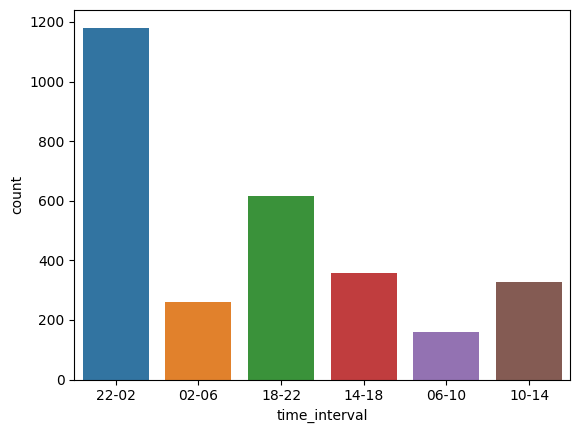

           days      Ratio
Salı        451  15.530303
Pazartesi   435  14.979339
Cuma        433  14.910468
Pazar       417  14.359504
Perşembe    408  14.049587
Wednesday   388  13.360882
Cumartesi   372  12.809917
---------------------------------------------


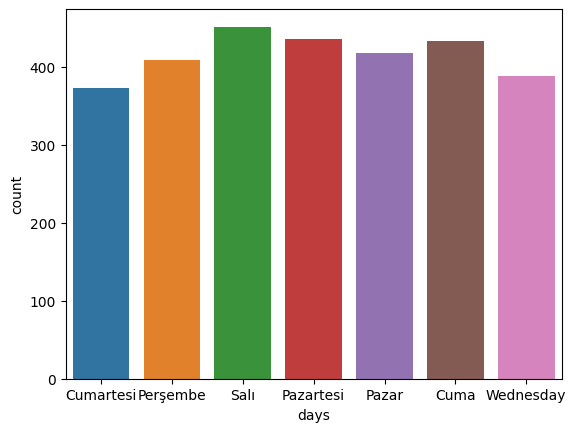

          seasons      Ratio
Kış           999  34.400826
Sonbahar      705  24.276860
Yaz           633  21.797521
İlkbahar      567  19.524793
---------------------------------------------


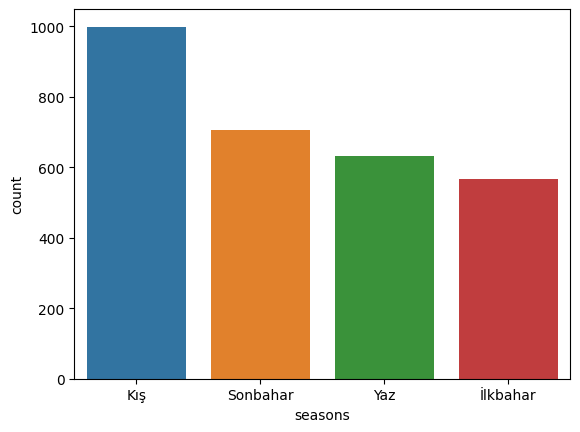

In [13]:
# Target variable analysis
cols = ["time_interval", "days", "seasons"]

def summary(dataframe, col_name, plot=False):
    # negatif tweetler için hedef değişken analizi
    dataframe = dataframe.loc[df["label"] == "negative"]
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("---------------------------------------------")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

for col in cols:
    summary(df, col, plot=True)

In [14]:
def data_preparation(dataframe, tf_idfVectorizer):
    """
    Prepare data for model,
        put "label" variable into Label Encoder.
        put "tweet" variable into TF-IDF.
    
    :param dataframe: dataframe
    :param tf_idfVectorizer: TF-IDF Model

    
    :return x: TF_IDF matrix
    :return y: the dependent variable 
    
    """
    dataframe["tweet"] = dataframe["tweet"].str.lower()

    dataframe["label"].replace(-1, value="negative", inplace=True)
    dataframe["label"].replace(0, value="neutral", inplace=True)
    dataframe["label"].replace(1, value="positive", inplace=True)

    dataframe["label"] = LabelEncoder().fit_transform(dataframe["label"])

    dataframe.dropna(axis=0, inplace=True)
    X = tf_idfVectorizer.fit_transform(dataframe["tweet"])
    y = dataframe["label"]

    return X,y


In [15]:
def logistic_regression(X, y):
    """
    Creating Logistic Regression model

    :param X: TF-IDF matrix
    :param y: the dependent variable


    :return log_model: Model object
    """

    log_model = LogisticRegression(max_iter=10000).fit(X, y)
    cross_val_score(log_model,
                    X,
                    y,
                    scoring="accuracy",
                    cv=10).mean()
    return log_model

In [16]:
def tweets_21(dataframe_new, tweets):
    """
    lowercasing tweets in the test dataset.

    :param dataframe_new: dataframe containing tweets
    :param tweets: variable containing tweets in dataframe_new

    :return dataframe_new: edited dataframe

    """

    dataframe_new[tweets] = dataframe_new[tweets].apply(
        lambda x: " ".join(x.lower() for x in x.split()))
    
    return dataframe_new

In [17]:
def predict_new_tweet(dataframe_new, log_model, tf_idfVectorizer):
    """
    Predicting tweets that belong the year 2021 with the Logistic 
    Regression model created.

    :param dataframe_new: edited dataframe for input to model
    :log_model: Logistic Regression model object
    :tf_idfVectorizer: TF_IDF Vectorizer object
    
    :return dataframe_new: dataframe that prediction results added
    """

    tweet_tfidf = tf_idfVectorizer.transform(dataframe_new["tweet"])
    predictions = log_model.predict(tweet_tfidf)
    dataframe_new["label"] = predictions
    return dataframe_new


In [18]:
def main():

    tf_idfVectorizer = TfidfVectorizer()
    X, y = data_preparation(df, tf_idfVectorizer)
    log_model = logistic_regression(X,y)
    dataframe_new = pd.read_csv("tweets_21.csv")
    predicted_df = predict_new_tweet(dataframe_new, log_model, tf_idfVectorizer)
    print(predicted_df.head(10))

In [19]:
if __name__ == "__main__":
    print("The process has started.")
    main()

The process has started.
              tweet_id                                              tweet                 date  label
0  1344798002490314752  Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...  2021-01-01 03:10:03      1
1  1344799527673470977  Bu yılbaşı da saat tam 00:00'da swni seviyorum...  2021-01-01 03:16:07      1
2  1344799907719348226  tam 00.00da naptınız ben her yıl tam bu vakit ...  2021-01-01 03:17:37      1
3  1344800782802165762  00:00'da havai fişek gösterisi yapıldı tam dib...  2021-01-01 03:21:06      1
4  1344805589990453249  31 aralık saat 00.00 da yeni yılımızı kutlayan...  2021-01-01 03:40:12      1
5  1344838906609606658  Saat 23:00 olmadan sızmışım.  Bütün senenin yo...  2021-01-01 05:52:35      1
6  1344845204965232640  yalnızlıktan ve sıkıntıdan şimdide kitaplara s...  2021-01-01 06:17:37      1
7  1344856870759129088  askerde 9da yat emri alıp uyuyup gece tam 00.0...  2021-01-01 07:03:58      1
8  1344893883554164736  Dertlerimi yazıyorum buraya, herk